In [15]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [40]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [3]:
batch_size = 4
image_size = 256
image_final_size = 224
hidden_size = 4096
num_layers = 1
MAX_LENGTH =25
EMBBEING_SIZE = 10
START_TOKEN ='<start>'
END_TOKEN = '<end>'
PADDINGS = '<pad>'
unknown_tok= '<unk>'
NO_SAMPLES = 30
MIN_FREQ = 4
IMAGES_PATH = "Flicker8k_Dataset"
# """"
# <S_TOK> = 1 , <S_TOK> - START TOKEN
# <E_TOK> = 2 , <E_TOK> - END TOKEN
# <P_TOK> = 0 , <P_TOK> - PADDINGS TOKEN
# """

In [ ]:
#caption = torch.randint(low=0, high=9, size=(10,))

In [ ]:
#caption

tensor([0, 6, 3, 6, 8, 4, 5, 0, 7, 6])

In [ ]:
#caption.shape

torch.Size([1, 10])

In [ ]:
#c = caption.view(1,10,1)

In [9]:
path_files = ['/content/10815824_2997e03d76.jpg','/content/12830823_87d2654e31.jpg','/content/17273391_55cfc7d3d4.jpg',
       '/content/19212715_20476497a3.jpg', '/content/23445819_3a458716c1.jpg',   '/content/27782020_4dab210360.jpg'
        , '/content/667626_18933d713e.jpg', '/content/54501196_a9ac9d66f2.jpg','/content/53043785_c468d6f931.jpg',
              '/content/50030244_02cd4de372.jpg', '/content/49553964_cee950f3ba.jpg','/content/47871819_db55ac4699.jpg'
              ]



In [4]:
# prompt: transform image to size 256, crop it to 224,apply transformation, scale the RBG values to the gaussian
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_final_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




In [11]:
images = []
for path in path_files:
  image = Image.open(path)
  image = transform(image)
  images.append(image)


In [18]:
images[1].shape
# image_size : 3*224*224

torch.Size([3, 224, 224])

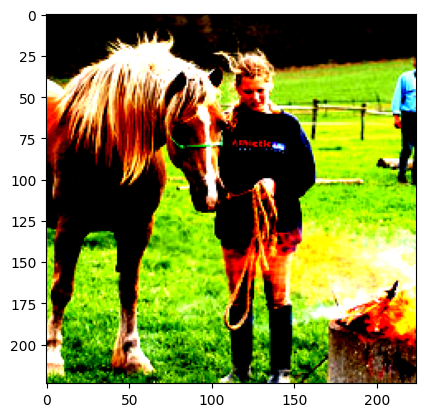

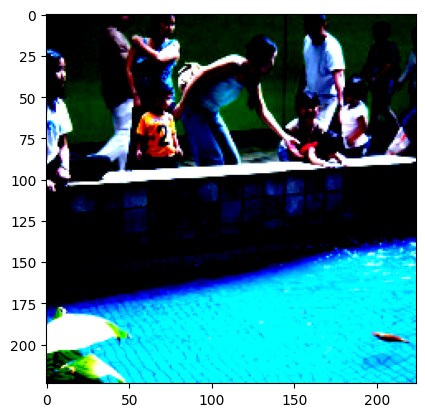

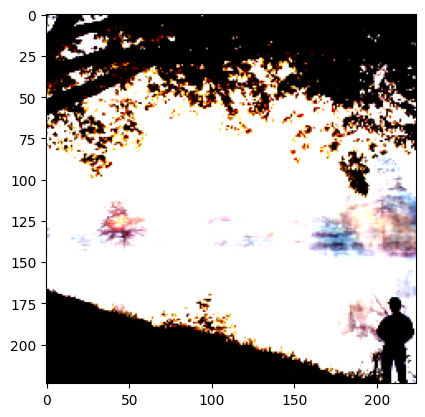

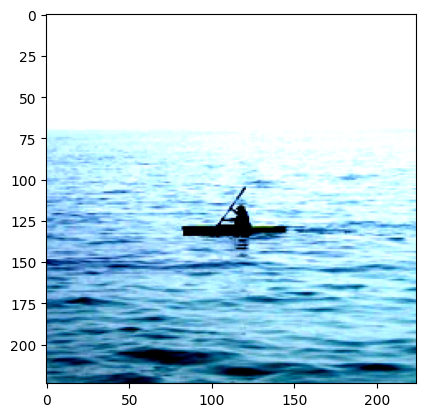

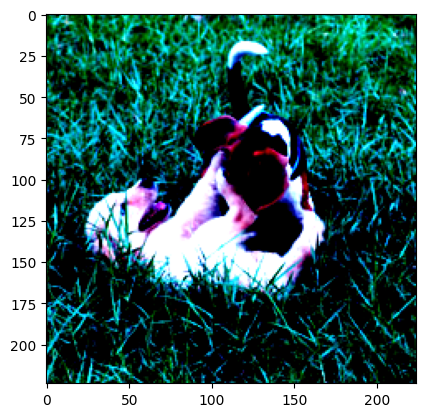

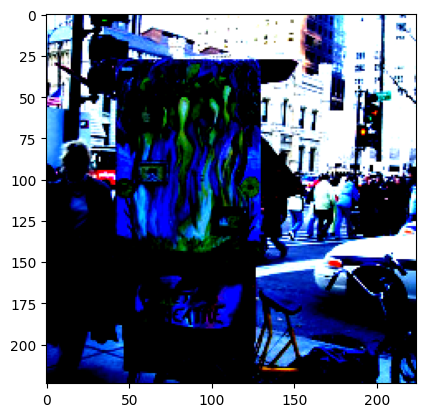

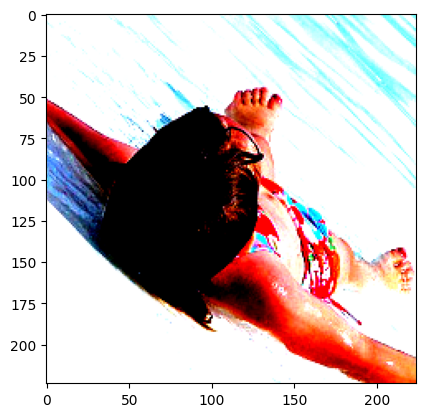

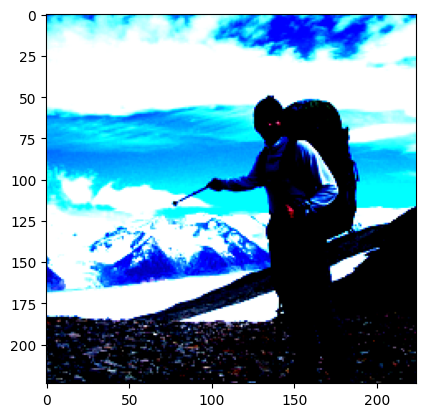

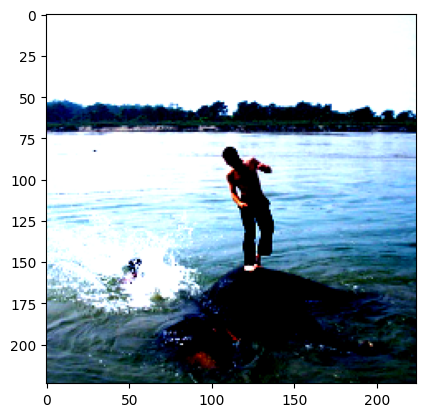

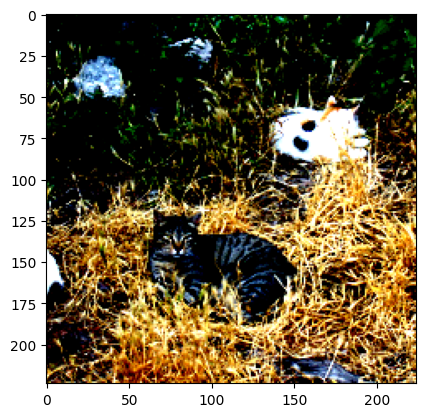

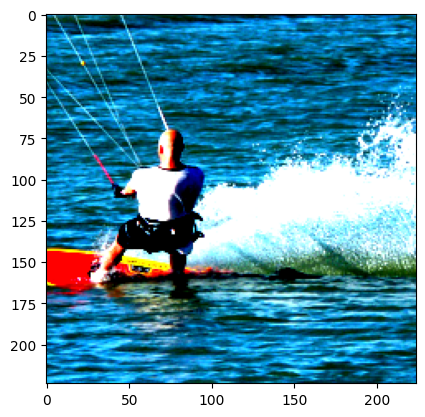

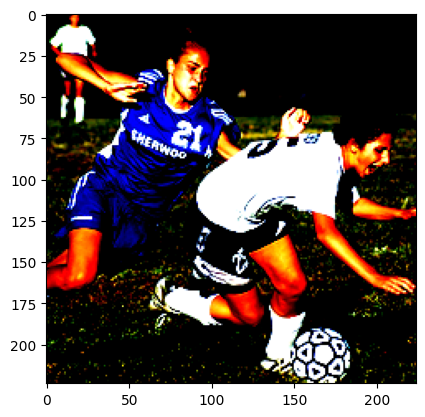

In [13]:
# prompt: show the image

import matplotlib.pyplot as plt

for image in images:

# Convert the image to a numpy array
  image_numpy = image.numpy()

# Transpose the image to the correct format for matplotlib (channels last)
  image_numpy = image_numpy.transpose(1, 2, 0)

# Display the image
  plt.imshow(image_numpy)
  plt.show()


In [7]:
import pandas as pd
file = pd.read_csv('/content/captions.txt')

In [23]:
file.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [44]:
file.iloc[0]['image']

'1000268201_693b08cb0e.jpg'

In [46]:
import os
image = Image.open(os.path.join(IMAGES_PATH,file.iloc[0]['image']))

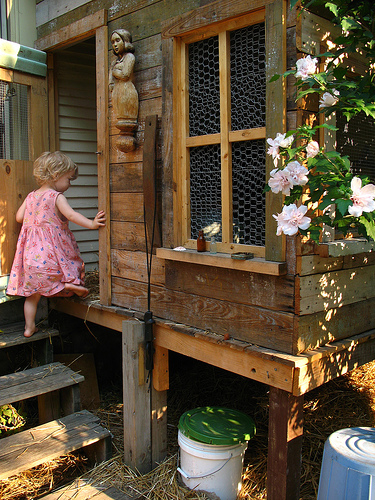

In [47]:
image


In [8]:
## consider only training dataset for the vocabulary
# only 100 for the training
def create_vocab(file,No_training, min_freq):

# """"
# <S_TOK> = 1 , <S_TOK> - START TOKEN
# <E_TOK> = 2 , <E_TOK> - END TOKEN
# <P_TOK> = 0 , <P_TOK> - PADDINGS TOKEN

    vocab = {}
    vocab[START_TOKEN] = 1
    vocab[END_TOKEN] = 2
    vocab[PADDINGS] = 0
    vocab[unknown_tok] = 3
    f = {}
    for i in range(0, No_training):

        caption = file['caption'][i]

### tokenization

        caption = caption.lower()
        tokens = caption.split()

        for j in tokens:
            if j in f:
                f[j] += 1
            else:
                f[j] = 1
### minimum frequency length to consider as the token
    c=4
    for i in f:
        if f[i] >= min_freq:
            vocab[i] = c
            c+=1

    return vocab



In [9]:
vocab = create_vocab(file,NO_SAMPLES,MIN_FREQ)

In [31]:
vocab

{'<start>': 1,
 '<end>': 2,
 '<pad>': 0,
 '<unk>': 3,
 'a': 4,
 'child': 5,
 'in': 6,
 'is': 7,
 'climbing': 8,
 'of': 9,
 'an': 10,
 '.': 11,
 'girl': 12,
 'little': 13,
 'the': 14,
 'to': 15,
 'black': 16,
 'dog': 17,
 'and': 18,
 'are': 19,
 'playing': 20,
 'with': 21,
 'on': 22,
 'white': 23,
 'brown': 24,
 'at': 25,
 'front': 26,
 'sitting': 27,
 'grass': 28,
 'man': 29,
 'bench': 30,
 'by': 31,
 'next': 32,
 'orange': 33,
 'hat': 34,
 'red': 35,
 'running': 36,
 'through': 37,
 'near': 38,
 ',': 39,
 'ball': 40,
 'water': 41,
 'boy': 42,
 'rock': 43,
 'over': 44,
 'snow': 45,
 'field': 46,
 'catch': 47,
 'yellow': 48,
 'lake': 49}

In [19]:
VOC_SIZE = len(vocab)

In [16]:
# creating own dataset model

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class MyDataset(Dataset):

    def __init__(self, data_file, transform, vocabulary,No_samples,Maxlen):

        self.data = data_file
        self.file_pointer = pd.read_csv(self.data)
        self.transform = transform
        self.vocabulary = vocabulary
        self.No_samples = No_samples
        self.Maxlen = Maxlen

    def __len__(self):
        return self.No_samples


    def __getitem__(self, idx):

        image = Image.open(os.path.join(IMAGES_PATH,self.file_pointer.iloc[idx]['image']))
        caption  = self.file_pointer.iloc[idx, 1]


        ## make a tensor vector which has start, end, padding token
        ## and return the caption
        ## of length - Maxlen
        ## tokenization
        caption = caption.lower()
        caption = caption.split()
        vec = torch.zeros(self.Maxlen, dtype=torch.long)
        vec[0] = self.vocabulary[START_TOKEN]

        for i in range(1, self.Maxlen-1):

            if i < len(caption):
                if caption[i] in self.vocabulary:
                    vec[i] = self.vocabulary[caption[i]]
                else:
                    vec[i] = self.vocabulary[unknown_tok]
            else:
                vec[i] = self.vocabulary[PADDINGS]



        vec[24] = self.vocabulary[END_TOKEN]
        if self.transform:

            image = self.transform(image)

        return image, vec





In [20]:
# prompt: create a tensor of zeros of length 25
## test the data loader
dataset = MyDataset('/content/captions.txt',transform,vocab,NO_SAMPLES,MAX_LENGTH)

In [21]:
import os
dataset[0]

(tensor([[[-0.9020, -0.9705, -1.1247,  ..., -0.6452, -0.2513, -0.2684],
          [-0.9877, -1.0048, -1.1760,  ..., -1.5870, -0.6109, -0.7308],
          [-0.9363, -1.0219, -1.1418,  ..., -1.3644, -1.5185, -1.5357],
          ...,
          [-1.7754, -1.8953, -1.8097,  ..., -1.5528, -1.5185, -1.5870],
          [-1.8097, -1.9124, -1.8439,  ..., -1.6384, -1.7240, -1.7583],
          [-1.6384, -1.7583, -1.8268,  ..., -1.5014, -1.4329, -1.3987]],
 
         [[-0.8627, -1.0378, -1.2654,  ...,  0.3627,  0.6078,  0.5553],
          [-0.8452, -0.8277, -1.1078,  ..., -1.0378,  0.3277, -0.0574],
          [-0.8102, -0.8627, -1.1253,  ..., -0.9153, -1.0728, -1.2654],
          ...,
          [-1.7731, -1.8081, -1.7381,  ..., -1.6331, -1.6155, -1.6506],
          [-1.7731, -1.8256, -1.7906,  ..., -1.7031, -1.7381, -1.7381],
          [-1.5455, -1.5980, -1.7556,  ..., -1.5980, -1.5280, -1.5105]],
 
         [[-0.8633, -1.1073, -1.4559,  ..., -1.0550, -0.8110, -0.7936],
          [-0.9330, -0.9330,

In [71]:
dataset[1]

(tensor([[[-0.9020, -0.9705, -1.1247,  ..., -0.6452, -0.2513, -0.2684],
          [-0.9877, -1.0048, -1.1760,  ..., -1.5870, -0.6109, -0.7308],
          [-0.9363, -1.0219, -1.1418,  ..., -1.3644, -1.5185, -1.5357],
          ...,
          [-1.7754, -1.8953, -1.8097,  ..., -1.5528, -1.5185, -1.5870],
          [-1.8097, -1.9124, -1.8439,  ..., -1.6384, -1.7240, -1.7583],
          [-1.6384, -1.7583, -1.8268,  ..., -1.5014, -1.4329, -1.3987]],
 
         [[-0.8627, -1.0378, -1.2654,  ...,  0.3627,  0.6078,  0.5553],
          [-0.8452, -0.8277, -1.1078,  ..., -1.0378,  0.3277, -0.0574],
          [-0.8102, -0.8627, -1.1253,  ..., -0.9153, -1.0728, -1.2654],
          ...,
          [-1.7731, -1.8081, -1.7381,  ..., -1.6331, -1.6155, -1.6506],
          [-1.7731, -1.8256, -1.7906,  ..., -1.7031, -1.7381, -1.7381],
          [-1.5455, -1.5980, -1.7556,  ..., -1.5980, -1.5280, -1.5105]],
 
         [[-0.8633, -1.1073, -1.4559,  ..., -1.0550, -0.8110, -0.7936],
          [-0.9330, -0.9330,

In [22]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [79]:
for batch in dataloader:
    data, labels = batch
    print(f"Data batch shape: {data.shape}")
    print(f"Labels batch shape: {labels.shape}")


Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 25])
Data batch shape: torch.Size([4, 3, 224, 22

In [23]:

import torch.optim as optim


class Seq2SeqModel(nn.Module):

    def __init__(self, voc_dim=VOC_SIZE, emb_dim=EMBBEING_SIZE, num_layers=1, hid_dim=hidden_size):
        super(Seq2SeqModel, self).__init__()

        # using CNN to extract features
        self.conv1 = nn.Conv2d(3, 10, 6, padding=3)
        self.conv2 = nn.Conv2d(10, 64, 6, padding=3)
        self.conv3 = nn.Conv2d(64, 128, 6, padding=3)
        self.conv4 = nn.Conv2d(128, 256, 6, padding=3)
        self.conv5 = nn.Conv2d(256, 512, 6, padding=3)
        self.conv6 = nn.Conv2d(512, 1024, 6, padding=3)
        self.conv7 = nn.Conv2d(1024, 2048, 6, padding=3)
        self.conv8 = nn.Conv2d(2048, 4096, 6, padding=3)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        # LSTM network
        self.voc_dim = voc_dim
        self.hid_dim = hid_dim
        self.emb_dim = emb_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers, batch_first=True)
        self.embedding = nn.Embedding(voc_dim, emb_dim)
        self.dense = nn.Linear(hid_dim, voc_dim)

    def forward(self, x, x0):
        # x - image, x0 - caption

        # CNN feature extraction
        x = self.maxpool(torch.relu(self.conv1(x)))
        x = self.maxpool(torch.relu(self.conv2(x)))
        x = self.maxpool(torch.relu(self.conv3(x)))
        x = self.maxpool(torch.relu(self.conv4(x)))
        x = self.maxpool(torch.relu(self.conv5(x)))
        x = self.maxpool(torch.relu(self.conv6(x)))
        x = self.maxpool(torch.relu(self.conv7(x)))
        x = self.maxpool(torch.relu(self.conv8(x)))
        x = self.flatten(x)

        # Reshape CNN output to match LSTM hidden state shape
        x = x.view(1, batch_size, -1)

        # Initialize LSTM hidden state
        h_0 = x
        c_0 = torch.zeros(self.num_layers, batch_size, self.hid_dim).to(x.device)

        # Embedding and LSTM processing
        e = self.embedding(x0)  # x0 is expected to be of shape (batch_size, seq_len)
        o, (h_n, c_n) = self.lstm(e, (h_0, c_0))

        # Dense layer for generating predictions
        o = self.dense(o)
        o = torch.sigmoid(o)

        return o, (h_n, c_n)

# Example usage
model = Seq2SeqModel()



In [ ]:
# images = torch.randn(batch_size, 3, 224, 224)  # Example image tensor
# captions = torch.randint(0, 10, (batch_size, 5))  # Example caption tensor

# outputs, (hn, cn) = model(images, captions)
# print(outputs.shape)


torch.Size([64, 5, 10])


In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [26]:
# prompt: how to use the device

# Check if a GPU device is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)


Seq2SeqModel(
  (conv1): Conv2d(3, 10, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(10, 64, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv3): Conv2d(64, 128, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv4): Conv2d(128, 256, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv5): Conv2d(256, 512, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv6): Conv2d(512, 1024, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv7): Conv2d(1024, 2048, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv8): Conv2d(2048, 4096, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lstm): LSTM(10, 4096, batch_first=True)
  (embedding): Embedding(31, 10)
  (dense): Linear(in_features=4096, out_features=31, bias=True)
)

In [27]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, captions in dataloader:
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()

        outputs, _ = model(images, captions)
        outputs = outputs.view(-1, outputs.size(-1))
        captions = captions.view(-1)
        loss = criterion(outputs, captions)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch loss: {epoch_loss:.4f}')

In [ ]:
train(model, dataloader, criterion, optimizer, device)

In [39]:
# optimizer.zero_grad()
# outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_len, voc_dim)
# captions = captions.view(-1)  # (batch_size * seq_len)
# running_loss = 0.0
#         # Compute the loss
# loss = criterion(outputs, captions)
# loss.backward()
# optimizer.step()


In [ ]:
# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the model
optimizer = optim.Adam(model.parameters(), lr=0.001)
